In [1]:
import math
import pandas as pd
import xarray as xr
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from geocube.api.core import make_geocube
import rioxarray
import xesmf as xe
from cutshapefile import transform_from_latlon, rasterize
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## GBD forecast

In [3]:
bm = {
    'china': {
        'yll': {
            'ncd': {
                '2016': {
                    'mean': 165_968,
                    'lower': 162_300.56,
                    'upper': 169_991.72,
                },
                '2040': {
                    'mean': 184_016.09,
                    'lower': 141_760.04,
                    'upper': 236_119.62,
                }
            },
            'lri': {
                '2016': {
                    'mean': 3_510.50,
                    'lower': 3_181.07,
                    'upper': 4_125.98,
                },
                '2040': {
                    'mean': 2_861.66,
                    'lower': 2_004.11,
                    'upper': 4_233.72,
                }
            },
            'copd': {
                '2016': {
                    'mean': 12_286.52,
                    'lower': 11_764.69,
                    'upper': 13_513.27,
                },
                '2040': {
                    'mean': 17_563.71,
                    'lower': 7_371.23,
                    'upper': 37_672.46,
                }
            }
        },
        'mort': {
            'ncd': {
                '2016': {
                    'mean': 8_558.79,
                    'lower': 8_378.23,
                    'upper': 8_733.13,
                },
                '2040': {
                    'mean': 13_078.35,
                    'lower': 10_619.30,
                    'upper': 16_029.41,
                }
            },
            'lri': {
                '2016': {
                    'mean': 152.62,
                    'lower': 138.09,
                    'upper': 189.57,
                },
                '2040': {
                    'mean': 260.08,
                    'lower': 187.51,
                    'upper': 366.77,
                }
            },
            'copd': {
                '2016': {
                    'mean': 876.27,
                    'lower': 839.48,
                    'upper': 969.50,
                },
                '2040': {
                    'mean': 1_521.64,
                    'lower': 638.64,
                    'upper': 3_263.44,
                }
            }
        }
    }
}

In [120]:
# the values in the dictionaries were all in 1,000s
df_bm_china_mort_ncd = pd.DataFrame.from_dict(bm['china']['mort']['ncd']).T * 1_000
df_bm_china_mort_lri = pd.DataFrame.from_dict(bm['china']['mort']['lri']).T * 1_000
df_bm_china_mort_copd = pd.DataFrame.from_dict(bm['china']['mort']['copd']).T * 1_000

df_bm_china_yll_ncd = pd.DataFrame.from_dict(bm['china']['yll']['ncd']).T * 1_000
df_bm_china_yll_lri = pd.DataFrame.from_dict(bm['china']['yll']['lri']).T * 1_000
df_bm_china_yll_copd = pd.DataFrame.from_dict(bm['china']['yll']['copd']).T * 1_000

In [121]:
dfs = {
    'mort_ncd': df_bm_china_mort_ncd,
    'mort_lri': df_bm_china_mort_lri,
    'mort_copd': df_bm_china_mort_copd,
    'yll_ncd': df_bm_china_yll_ncd,
    'yll_lri': df_bm_china_yll_lri,
    'yll_copd': df_bm_china_yll_copd,
}

In [129]:
years = pd.date_range('2015-01-01', periods=36, freq='Y')

outcomes = ['mort', 'yll']
causes = ['ncd', 'lri', 'copd']
metrics = ['mean', 'lower', 'upper']

df_bm_china = pd.DataFrame(index=years)

for outcome in outcome:
    for cause in causes:   
        for metric in metrics:
            df_bm_china[f'{outcome}_{cause}_{metric}'] = pd.Series(dtype='float64')
            for index, year in enumerate(['2016', '2040']):
                mean, lower, upper = dfs[f'{outcome}_{cause}'].iloc[index].values
                df_bm_china.loc[year, f'{outcome}_{cause}_mean'] = mean
                df_bm_china.loc[year, f'{outcome}_{cause}_lower'] = lower
                df_bm_china.loc[year, f'{outcome}_{cause}_upper'] = upper

df_bm_china.head()

,mort_ncd_mean,mort_ncd_lower,mort_ncd_upper,mort_lri_mean,mort_lri_lower,mort_lri_upper,mort_copd_mean,mort_copd_lower,mort_copd_upper,yll_ncd_mean,yll_ncd_lower,yll_ncd_upper,yll_lri_mean,yll_lri_lower,yll_lri_upper,yll_copd_mean,yll_copd_lower,yll_copd_upper
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,8558790.0,8378230.0,8733130.0,152620.0,138090.0,189570.0,876270.0,839480.0,969500.0,165968000.0,162300560.0,169991720.0,3510500.0,3181070.0,4125980.0,12286520.0,11764690.0,13513270.0
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
df = df_bm_china.interpolate(method='linear', limit_area='inside')

index = df.index
df = df.reset_index().drop('index', 1)

In [154]:
# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

# Create copy of data to remove NaNs for curve fitting
fit_df = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    df[col][x] = func(x, *col_params[col])

/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [156]:
df.index = index

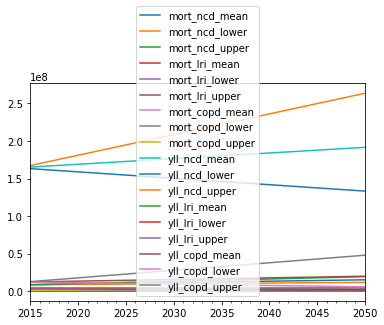

In [160]:
df.plot();

In [240]:
comma_format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
colors = {
    'ncd': '#7fc97f',
    'lri': '#beaed4',
    'copd': '#fdc086'
}
xticks = [dt.year if f'{dt.year}'[-1] == '0' or f'{dt.year}'[-1] == '5' else '' for dt in df.index]
def make_plot(index, df, outcome, cause, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    ax.get_xaxis().set_major_locator(matplotlib.dates.YearLocator(5))
    ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.ylim([df[f'{outcome}_{cause}_lower'].min(), df[f'{outcome}_{cause}_upper'].max()])
    plt.title(title)
    plt.plot(df.index, df[f'{outcome}_{cause}_mean'], color=colors[cause], label=cause.upper())
    plt.fill_between(df.index, df[f'{outcome}_{cause}_lower'], df[f'{outcome}_{cause}_upper'], facecolor=colors[cause], alpha=0.2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


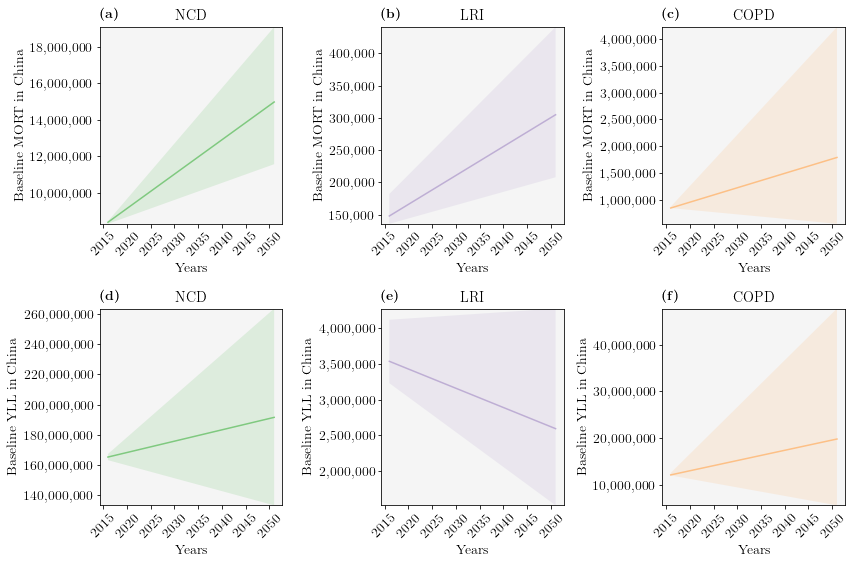

In [242]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, df, 'mort', 'ncd', 'Baseline MORT in China', 'NCD')
make_plot(1, df, 'mort', 'lri', 'Baseline MORT in China', 'LRI')
make_plot(2, df, 'mort', 'copd', 'Baseline MORT in China', 'COPD')
make_plot(3, df, 'yll', 'ncd', 'Baseline YLL in China', 'NCD')
make_plot(4, df, 'yll', 'lri', 'Baseline YLL in China', 'LRI')
make_plot(5, df, 'yll', 'copd', 'Baseline YLL in China', 'COPD')

gs.tight_layout(fig, rect=[0, 0, 1, 1])

plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_climate/baseline_health_china.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_climate/baseline_health_china.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [ ]:
df['NAME_0'] = 'China'

gdf = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp')

gdf_merged = gdf.merge(df.reset_index(), left_on='NAME_0', right_on='NAME_0')
gdf_merged.index = index

columns = [column for column in df.columns if 'mort' in column or 'yll' in column]
years = [str(year) for year in np.arange(2015, 2055, 5)]

global_grid = xr.Dataset(
    {'lat': (['lat'], np.arange(-60, 85, 0.25)),
     'lon': (['lon'], np.arange(-180, 180, 0.25)),}
)

In [309]:
for year in years:
    for column in columns:
        cube = make_geocube(
            vector_data=gdf_merged[year], 
            measurements=[column], 
            resolution=(0.25, 0.25))
        cube[column].rio.to_raster(
            f'/nfs/a68/earlacoa/health/GBD_forecast/gdf_merged_china_{year}_{column}.tif')

In [ ]:
for year in years:
    for column in columns:
        ds = rioxarray.open_rasterio(
            f'/nfs/a68/earlacoa/health/GBD_forecast/gdf_merged_china_{year}_{column}.tif')
        ds = ds.rename({'x': 'lon', 'y': 'lat'})
        regridder = xe.Regridder(ds, global_grid, 'bilinear', reuse_weights=True)
        ds_regrid = regridder(ds)
        ds_regrid_clean = ds_regrid.isel(band=0).to_dataset(name=column).reset_coords().drop(['band', 'spatial_ref'])
        ds_regrid_clean.to_netcdf(f'/nfs/a68/earlacoa/health/GBD_forecast/GBD_forecast_bm_china_{year}_{column}.nc')

In [311]:
ds_regrid_clean

<xarray.Dataset>
Dimensions:         (lat: 580, lon: 1440)
Coordinates:
  * lon             (lon) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat             (lat) float64 -60.0 -59.75 -59.5 -59.25 ... 84.25 84.5 84.75
Data variables:
    yll_copd_upper  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [302]:
xx, yy = np.meshgrid(ds_regrid_clean.lon.values, ds_regrid_clean.lat.values)

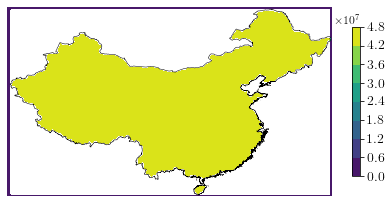

In [312]:
fig = plt.figure(1, figsize=(6, 6))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp').geometries(),                           
    ccrs.PlateCarree(), facecolor='none')
ax.patch.set_visible(False)
ax.spines['geo'].set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
cmap = 'viridis'
norm = matplotlib.colors.Normalize(vmin=ds_regrid_clean[column].min(), vmax=ds_regrid_clean[column].max())
im = ax.contourf(xx, yy, ds_regrid_clean[column], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(im, norm=norm, cmap=cmap, shrink=0.5)
cb.set_label('', size=14)
cb.ax.tick_params(labelsize=14)

gs.tight_layout(fig, rect=[0, 0, 1.0, 0.75]) 

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [313]:
ds_pop = xr.open_dataset('/nfs/a68/earlacoa/population/count/projections/Base_year_data_2000_NetCDF/2000total.nc')['2000total']
ds_pop

<xarray.DataArray '2000total' (lat: 1117, lon: 2880)>
[3216960 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * lat      (lat) float64 83.69 83.56 83.44 83.31 ... -55.56 -55.69 -55.81
Attributes:
    long_name:       2000total
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

In [ ]:
for year in ['2020', '2030', '2040', '2050']:
    for column in columns:
        ds = xr.open_dataset(f'/nfs/a68/earlacoa/health/GBD_forecast/GBD_forecast_bm_china_{year}_{column}.nc')
        regridder = xe.Regridder(ds, ds_pop, 'bilinear', reuse_weights=True)
        ds_regrid = regridder(ds)
        ds_regrid.to_netcdf(f'/nfs/a68/earlacoa/health/GBD_forecast/GBD_forecast_bm_china_{year}_{column}_popgrid_0.125deg.nc')

In [328]:
ds_regrid * ds_pop

<xarray.Dataset>
Dimensions:         (lat: 1117, lon: 2880)
Coordinates:
  * lon             (lon) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat             (lat) float64 83.69 83.56 83.44 ... -55.56 -55.69 -55.81
Data variables:
    yll_copd_upper  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [324]:
xx, yy = np.meshgrid(ds_regrid.lon.values, ds_regrid.lat.values)

In [331]:
values = ds_regrid[column] * ds_pop

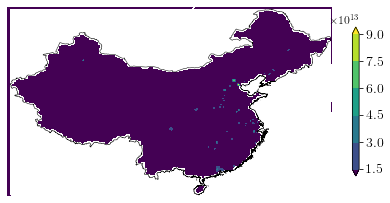

In [332]:
fig = plt.figure(1, figsize=(6, 6))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp').geometries(),                           
    ccrs.PlateCarree(), facecolor='none')
ax.patch.set_visible(False)
ax.spines['geo'].set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
cmap = 'viridis'
norm = matplotlib.colors.Normalize(vmin=values.min(), vmax=values.max())
im = ax.contourf(xx, yy, values, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend='both')
cb = plt.colorbar(im, norm=norm, cmap=cmap, shrink=0.5)
cb.set_label('', size=14)
cb.ax.tick_params(labelsize=14)

gs.tight_layout(fig, rect=[0, 0, 1.0, 0.75]) 

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [333]:
ds_pop

<xarray.DataArray '2000total' (lat: 1117, lon: 2880)>
[3216960 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * lat      (lat) float64 83.69 83.56 83.44 83.31 ... -55.56 -55.69 -55.81
Attributes:
    long_name:       2000total
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

## International Futures

In [2]:
path = '/nfs/b0122/Users/earlacoa/health/IFs'

gdf = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp')

In [150]:
for year in ['2020', '2030', '2040', '2050']:
    df = pd.read_csv(f'{path}/pop_age_china_{year}.csv', skiprows=2)[['Age Cohort', 'Total']]
    
    df['Age Cohort'] = [age.replace(' ', '').replace('-', '_') for age in df['Age Cohort'].values]
    
    for age in ['0_4', '5_9', '10_14', '15_19', '20_24']:
        df = df[df['Age Cohort'] != age]

    total_80up = 0.0
    for age in ['80_84', '85_89', '90_94', '95_99', '100+']:
        total_80up += df.loc[df['Age Cohort']  == age]['Total'].values

    df = df.append({'Age Cohort': '80up', 'Total': total_80up[0]}, ignore_index=True)

    for age in ['80_84', '85_89', '90_94', '95_99', '100+']:
        df = df[df['Age Cohort'] != age]
    
    ages = df['Age Cohort'].values
    
    column = 'Total'
    df[column] = df[column] / df[column].sum()
    
    df['NAME_0'] = 'China'
    
    gdf_merged = gdf.merge(df, left_on='NAME_0', right_on='NAME_0')
    
    for age in ages: 
        cube = make_geocube(
            vector_data=gdf_merged.loc[gdf_merged['Age Cohort'] == age], 
            measurements=[column], 
            resolution=(0.125, 0.125))
        
        cube[column].rio.to_raster(
            f'{path}/gdf_merged_pop_age_china_{year}_{age}.tif')
        
        ds = rioxarray.open_rasterio(
            f'{path}/gdf_merged_pop_age_china_{year}_{age}.tif')
        
        ds = ds.rename({'x': 'lon', 'y': 'lat'})
        
        regridder = xe.Regridder(ds, ds_pop, 'bilinear', reuse_weights=True)
        ds_regrid = regridder(ds)
        ds_regrid_clean = ds_regrid.isel(band=0).to_dataset(name=column).reset_coords().drop(['band', 'spatial_ref'])
        ds_regrid_clean.to_netcdf(f'{path}/IFs_pop_age_china_{year}_{age}.nc')

Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_2

<xarray.DataArray 'Total' ()>
array(0.1203454)


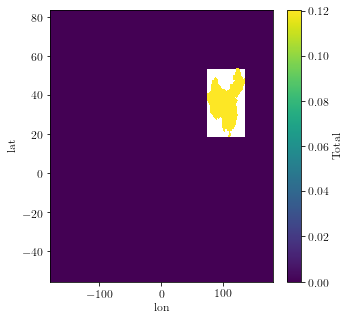

In [151]:
print(ds_regrid_clean[column].max())
ds_regrid_clean[column].plot();

In [545]:
skiprows = {
    'ncd': 3,
    'lri': 2,
    'copd': 2
}
columns = {
    'ncd': 'Total',
    'lri': 'Respiratory Infections Total',
    'copd': 'Respiratory Total'
}

for year in ['2020', '2030', '2040', '2050']:
    for disease in ['ncd', 'lri', 'copd']:
        column = columns[disease]
        df = pd.read_csv(f'{path}/bm_{disease}_mort-per-1000_china_{year}.csv', skiprows=skiprows[disease])[['Age Cohort', column]]

        df['Age Cohort'] = [age.replace(' ', '').replace('-', '_') for age in df['Age Cohort'].values]

        for age in ['Infants', '1_4', '5_9', '10_14', '15_19', '20_24']:
            df = df[df['Age Cohort'] != age]

        total_80up = []
        for age in ['80_84', '85_89', '90_94', '95_99']:
            total_80up.append(df.loc[df['Age Cohort'] == age][column].values)

        # times by 0.5 as the average from gbd2017 for rates individually
        # above 80 years, as e.g. 95+ is way higher than 80-84 and the mean
        # alone wont account for this
        total_80up = np.mean(total_80up) * 0.5

        df = df.append({'Age Cohort': '80up', column: total_80up}, ignore_index=True)

        for age in ['80_84', '85_89', '90_94', '95_99']:
            df = df[df['Age Cohort'] != age]

        ages = df['Age Cohort'].values
    
        df[column] = df[column] / 1_000

        df['NAME_0'] = 'China'

        gdf_merged = gdf.merge(df, left_on='NAME_0', right_on='NAME_0')

        for age in ages:
            cube = make_geocube(
                vector_data=gdf_merged.loc[gdf_merged['Age Cohort'] == age], 
                measurements=[column], 
                resolution=(0.125, 0.125))

            cube[column].rio.to_raster(
                f'{path}/gdf_merged_bm_{disease}_mort_china_{year}_{age}.tif')

            ds = rioxarray.open_rasterio(
                f'{path}/gdf_merged_bm_{disease}_mort_china_{year}_{age}.tif')

            ds = ds.rename({'x': 'lon', 'y': 'lat'})

            regridder = xe.Regridder(ds, ds_pop, 'bilinear', reuse_weights=True)
            ds_regrid = regridder(ds)
            ds_regrid_clean = ds_regrid.isel(band=0).to_dataset(name=column).reset_coords().drop(['band', 'spatial_ref'])
            ds_regrid_clean.to_netcdf(f'{path}/IFs_bm_{disease}_mort_china_{year}_{age}.nc')

Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_284x491_1117x2880.nc
Reuse existing file: bilinear_2

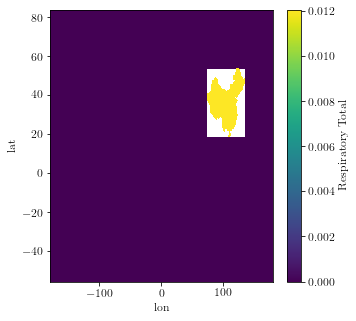

In [546]:
ds_regrid_clean[column].plot();

### plot

In [3]:
df_ages = {}
years = ['2020', '2050']
for year in years:
    df = pd.read_csv(f'{path}/pop_age_china_{year}.csv', skiprows=2)[['Age Cohort', 'Total']]
    
    df['Age Cohort'] = [age.replace(' ', '').replace('-', '_') for age in df['Age Cohort'].values]
    
    for age in ['0_4', '5_9', '10_14', '15_19', '20_24']:
        df = df[df['Age Cohort'] != age]

    total_80up = 0.0
    for age in ['80_84', '85_89', '90_94', '95_99', '100+']:
        total_80up += df.loc[df['Age Cohort']  == age]['Total'].values

    df = df.append({'Age Cohort': '80up', 'Total': total_80up[0]}, ignore_index=True)

    for age in ['80_84', '85_89', '90_94', '95_99', '100+']:
        df = df[df['Age Cohort'] != age]
    
    df['Age Cohort'] = [age.replace('_', ' to ') for age in df['Age Cohort'].values]
    ages = df['Age Cohort'].values
    
    column = 'Total'
    df[column] = df[column] / df[column].sum()
    
    df_ages.update({year: df})

In [4]:
del df3
df3 = df_ages['2020'].copy()
df3.reset_index(inplace=True)
key = [key for key in df3.keys() if 'Total' in key][0]
gbd = [110718580.8, 129096492.1, 100894600.1, 101645720, 121366280.3, 125103334.7, 94839582.5, 78555833.61, 70383715.73, 47855920.27, 29846507.02, 30262433.37]
df3['gbd'] = pd.DataFrame(gbd) / np.sum(gbd)
df3['diff'] = df3[key] / df3['gbd']
df3

NameError: name 'df3' is not defined

In [5]:
df_bms = {}

skiprows = {
    'ncd': 3,
    'lri': 2,
    'copd': 2
}
columns = {
    'ncd': 'Total',
    'lri': 'Respiratory Infections Total',
    'copd': 'Respiratory Total'
}

for year in ['2020', '2030', '2040', '2050']:
    for disease in ['ncd', 'lri', 'copd']:
        column = columns[disease]
        df = pd.read_csv(f'{path}/bm_{disease}_mort-per-1000_china_{year}.csv', skiprows=skiprows[disease])[['Age Cohort', column]]

        df['Age Cohort'] = [age.replace(' ', '').replace('-', '_') for age in df['Age Cohort'].values]

        for age in ['Infants', '1_4', '5_9', '10_14', '15_19', '20_24']:
            df = df[df['Age Cohort'] != age]

        total_80up = []
        for age in ['80_84', '85_89', '90_94', '95_99']:
            total_80up.append(df.loc[df['Age Cohort'] == age][column].values)

        total_80up = np.mean(total_80up) * 0.5

        df = df.append({'Age Cohort': '80up', column: total_80up}, ignore_index=True)

        for age in ['80_84', '85_89', '90_94', '95_99']:
            df = df[df['Age Cohort'] != age]

        df['Age Cohort'] = [age.replace('_', ' to ') for age in df['Age Cohort'].values]
        ages = df['Age Cohort'].values

        #df[column] = df[column] / 100
        
        df_bms.update({f'{year}_{disease}': df})

In [643]:
del df3
df3 = df_bms['2020_ncd'].copy()
df3.reset_index(inplace=True)
key = [key for key in df3.keys() if 'Total' in key][0]
df3[key] = df3[key] / 1000
gbd = [29,46,60,108,238,410,494,1115,2036,2936,4933,11262]
df3['gbd'] = pd.DataFrame(gbd) / 100_000
df3['diff'] = df3[key] / df3['gbd']
df3

,index,Age Cohort,Total,gbd,diff
0,0,25 to 29,0.000279,0.00029,0.961379
1,1,30 to 34,0.000457,0.00046,0.993478
2,2,35 to 39,0.000605,0.00060,1.008833
3,3,40 to 44,0.001092,0.00108,1.010926
4,4,45 to 49,0.002416,0.00238,1.015042
5,5,50 to 54,0.004132,0.00410,1.007878
6,6,55 to 59,0.004961,0.00494,1.004170
7,7,60 to 64,0.011130,0.01115,0.998233
8,8,65 to 69,0.020020,0.02036,0.983306
9,9,70 to 74,0.028981,0.02936,0.987091


In [642]:
del df2
df2 = df_bms['2020_lri'].copy()
df2.reset_index(inplace=True)
key = [key for key in df2.keys() if 'Total' in key][0]
df2[key] = df2[key] / 1000
gbd = [0.7, 0.78, 0.77, 1.06, 2.03, 3.6, 4.2, 10, 19, 35, 76, 294]
df2['gbd'] = pd.DataFrame(gbd) / 100_000
df2['diff'] = df2[key] / df2['gbd']
df2

,index,Age Cohort,Respiratory Infections Total,gbd,diff
0,0,25 to 29,0.000006,0.000007,0.857143
1,1,30 to 34,0.000007,0.000008,0.871795
2,2,35 to 39,0.000007,0.000008,0.870130
3,3,40 to 44,0.000009,0.000011,0.877358
4,4,45 to 49,0.000018,0.000020,0.866995
5,5,50 to 54,0.000031,0.000036,0.858333
6,6,55 to 59,0.000036,0.000042,0.869048
7,7,60 to 64,0.000085,0.000100,0.853000
8,8,65 to 69,0.000169,0.000190,0.887895
9,9,70 to 74,0.000316,0.000350,0.904286


In [641]:
del df3
df3 = df_bms['2020_copd'].copy()
df3.reset_index(inplace=True)
key = [key for key in df3.keys() if 'Total' in key][0]
df3[key] = df3[key] / 1000
gbd = [0.4, 0.7, 0.9, 2.0, 5.4, 12.,7, 19, 63, 155, 314, 692, 1679]
df3['gbd'] = pd.DataFrame(gbd) / 100_000
df3['diff'] = df3[key] / df3['gbd']
df3

,index,Age Cohort,Respiratory Total,gbd,diff
0,0,25 to 29,0.000008,0.000004,1.900000
1,1,30 to 34,0.000013,0.000007,1.800000
2,2,35 to 39,0.000016,0.000009,1.744444
3,3,40 to 44,0.000032,0.000020,1.610000
4,4,45 to 49,0.000072,0.000054,1.337037
5,5,50 to 54,0.000154,0.000120,1.286667
6,6,55 to 59,0.000224,0.000070,3.204286
7,7,60 to 64,0.000702,0.000190,3.696842
8,8,65 to 69,0.001667,0.000630,2.646667
9,9,70 to 74,0.003408,0.001550,2.198903


In [6]:
ds_pop_2020 = xr.open_dataset('/nfs/a68/earlacoa/population/count/projections/SSP2/Total/NetCDF/ssp2_2020.nc')['ssp2_2020']
ds_pop_2050 = xr.open_dataset('/nfs/a68/earlacoa/population/count/projections/SSP2/Total/NetCDF/ssp2_2050.nc')['ssp2_2050']

xx, yy = np.meshgrid(ds_pop_2020.lon.values, ds_pop_2050.lat.values)

In [7]:
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp')
shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]

In [8]:
ds_pop_2020['shapefile'] = rasterize(shapes, ds_pop_2020.coords, longitude='lon', latitude='lat') 
ds_pop_2020['shapefile'] = ds_pop_2020.shapefile.where(cond=ds_pop_2020.shapefile!=0, other=1) 
ds_pop_2020 = ds_pop_2020.where(cond=ds_pop_2020.shapefile==1, other=np.nan)

In [9]:
ds_pop_2050['shapefile'] = rasterize(shapes, ds_pop_2050.coords, longitude='lon', latitude='lat') 
ds_pop_2050['shapefile'] = ds_pop_2050.shapefile.where(cond=ds_pop_2050.shapefile!=0, other=1) 
ds_pop_2050 = ds_pop_2050.where(cond=ds_pop_2050.shapefile==1, other=np.nan)

In [10]:
diff_pop = ds_pop_2050 - ds_pop_2020

In [11]:
colors = {
    '2020': '#7fc97f',
    '2050': '#beaed4'}

def make_bar_plot(index, df, year, outcome, cause, label, show_y_axis=True):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(year)
    if not show_y_axis:
        ax.axes.get_yaxis().set_visible(False)
    if outcome == 'age':
        plt.ylim([0, 0.15])
        plt.bar(df['Age Cohort'], df['Total'], color=colors[year])
    if outcome == 'bm':
        if cause == 'ncd':
            plt.bar(df['Age Cohort'], df['Total'], color=colors[year])
            plt.ylim([0, 200])
        if cause == 'lri':
            plt.bar(df['Age Cohort'], df['Respiratory Infections Total'], color=colors[year])
            plt.ylim([0, 7])
        if cause == 'copd':
            plt.bar(df['Age Cohort'], df['Respiratory Total'], color=colors[year])
            plt.ylim([0, 35])

In [12]:
comma_format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))

def make_map_plot(index, ds_pop, year, label, title):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    shape_feature = ShapelyFeature(
        Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                           
        ccrs.PlateCarree(), facecolor='none')
    ax.patch.set_visible(False)
    ax.spines['geo'].set_visible(False)
    ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    if year == '2020':
        cmap = 'viridis'
        norm = matplotlib.colors.LogNorm()
        im = ax.contourf(xx, yy, ds_pop, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend='both')
        cb = plt.colorbar(im, norm=norm, cmap=cmap, shrink=1.5)
    if year == '2050':
        cmap = 'BrBG'
        levels = np.linspace(-11_000, 11_000, 12)
        norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
        im = ax.contourf(xx, yy, ds_pop, cmap=cmap, norm=norm, levels=levels, transform=ccrs.PlateCarree(), extend='both')
        cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=1.5, format=comma_format)
    cb.set_label(label, size=14)
    cb.ax.tick_params(labelsize=14)
    plt.title(title)

/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/matplotlib/contour.py:1486: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


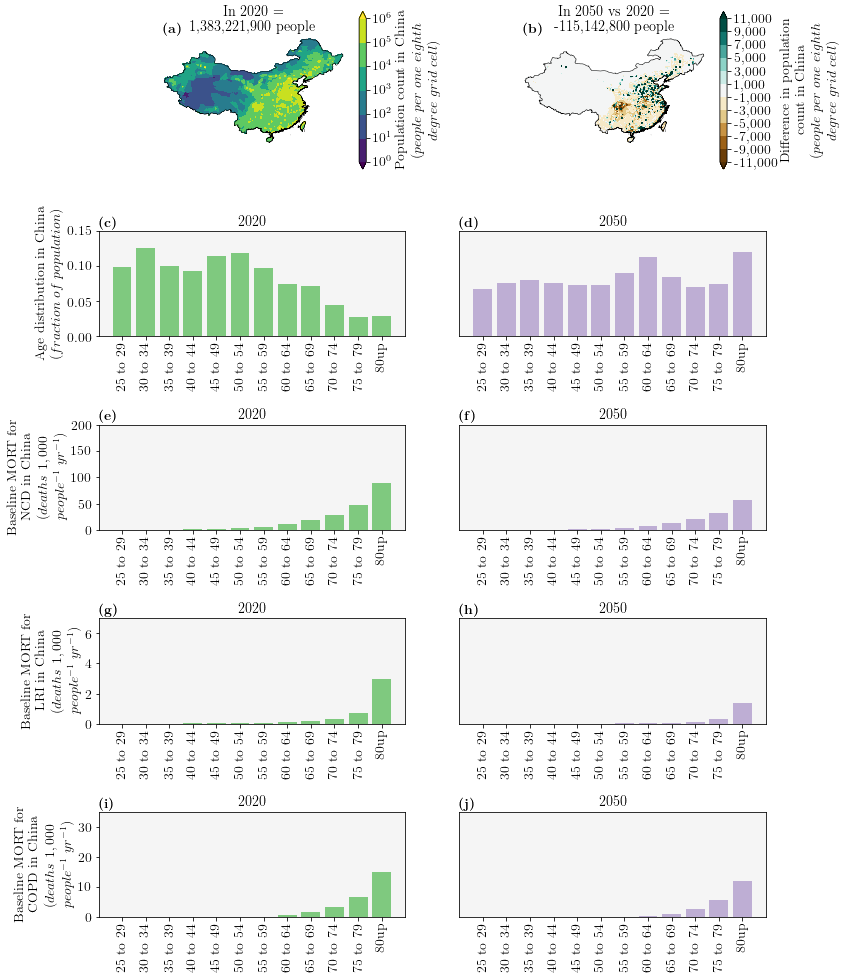

In [13]:
fig = plt.figure(1, figsize=(12, 20))
gs = gridspec.GridSpec(5, 2)

make_map_plot(0, ds_pop_2020, '2020', 'Population count in China\n($people$ $per$ $one$ $eighth$\n$degree$ $grid$ $cell$)', f'In 2020 =\n{round(int(ds_pop_2020.sum().values), -2):,} people')
make_map_plot(1, diff_pop, '2050', 'Difference in population\ncount in China\n($people$ $per$ $one$ $eighth$\n$degree$ $grid$ $cell$)', f'In 2050 vs 2020 =\n{round(int(diff_pop.sum().values), -2):,} people')

make_bar_plot(2, df_ages['2020'], '2020', 'age', '', 'Age distribution in China\n($fraction$ $of$ $population$)', show_y_axis=True)
make_bar_plot(3, df_ages['2050'], '2050', 'age', '', 'Age distribution in China\n($fraction$ $of$ $population$)', show_y_axis=False)
make_bar_plot(4, df_bms['2020_ncd'], '2020', 'bm', 'ncd', 'Baseline MORT for\nNCD in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=True)
make_bar_plot(5, df_bms['2050_ncd'], '2050', 'bm', 'ncd', 'Baseline MORT for\nNCD in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=False)
make_bar_plot(6, df_bms['2020_lri'], '2020', 'bm', 'lri', 'Baseline MORT for\nLRI in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=True)
make_bar_plot(7, df_bms['2050_lri'], '2050', 'bm', 'lri', 'Baseline MORT for\nLRI in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=False)
make_bar_plot(8, df_bms['2020_copd'], '2020', 'bm', 'copd', 'Baseline MORT for\nCOPD in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=True)
make_bar_plot(9, df_bms['2050_copd'], '2050', 'bm', 'copd', 'Baseline MORT for\nCOPD in China\n($deaths$ $1,000$\n$people^{-1}$ $yr^{-1}$)', show_y_axis=False)

gs.tight_layout(fig, rect=[0, 0, 1, 0.7])

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_climate/pop-count_age_baseline-mort_china.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_climate/pop-count_age_baseline-mort_china.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [19]:
df_ages['2050']['2050 - 2020'] = df_ages['2050'].Total - df_ages['2020'].Total

In [20]:
df_ages['2050']

,Age Cohort,Total,2050 - 2020
0,25 to 29,0.067242,-0.031691
1,30 to 34,0.076645,-0.050022
2,35 to 39,0.080003,-0.019671
3,40 to 44,0.076483,-0.017126
4,45 to 49,0.072661,-0.042359
5,50 to 54,0.073463,-0.046143
6,55 to 59,0.090488,-0.007274
7,60 to 64,0.113156,0.038334
8,65 to 69,0.084264,0.012660
9,70 to 74,0.070776,0.025473


In [23]:
df_ages['2020'].iloc[-5:].Total.sum()

0.2487292526164146

In [24]:
df_ages['2050'].iloc[-5:].Total.sum()

0.46301560063266745

In [435]:
115_142_800 / 1_383_221_900

0.08324246456768794

In [605]:
gbd_ncd = np.load('/nfs/a68/earlacoa/health/GBD2017/GBD2017_baseline_mortality_MORT_global_2015_array_ncd_both_0.25deg.npz')
gbd_copd = np.load('/nfs/a68/earlacoa/health/GBD2017/GBD2017_baseline_mortality_MORT_global_2015_array_copd_both_0.25deg.npz')
gbd_lri = np.load('/nfs/a68/earlacoa/health/GBD2017/GBD2017_baseline_mortality_MORT_global_2015_array_lri_both_0.25deg.npz')

In [610]:
ifs_ncd = xr.open_dataset('/nfs/b0122/Users/earlacoa/health/IFs/IFs_bm_ncd_mort_china_2020_75_79.nc')['Total']
ifs_copd = xr.open_dataset('/nfs/b0122/Users/earlacoa/health/IFs/IFs_bm_copd_mort_china_2020_75_79.nc')['Respiratory Total']
ifs_lri = xr.open_dataset('/nfs/b0122/Users/earlacoa/health/IFs/IFs_bm_lri_mort_china_2020_75_79.nc')['Respiratory Infections Total']

In [593]:
global_grid = xr.Dataset(
    {'lat': (['lat'], np.arange(-60, 85, 0.25)), 
     'lon': (['lon'], np.arange(-180, 180, 0.25)),}
)

In [594]:
regridder = xe.Regridder(
    ifs, 
    global_grid, 
    'bilinear'
)

Create weight file: bilinear_1117x2880_580x1440.nc


In [611]:
ifs_ncd_regrid = regridder(ifs_ncd)
ifs_copd_regrid = regridder(ifs_copd)
ifs_lri_regrid = regridder(ifs_lri)

In [625]:
test_ncd = ifs_ncd_regrid.fillna(0) - gbd_ncd['i_mort_ncd_both_mean_75_79']
test_copd = ifs_copd_regrid.fillna(0) - gbd_copd['i_mort_copd_both_mean_75_79']
test_lri = ifs_lri_regrid.fillna(0) - gbd_lri['i_mort_lri_both_mean_75_79']

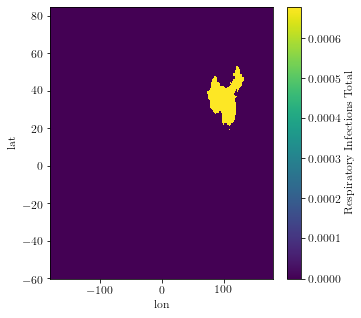

In [632]:
ifs_lri_regrid.fillna(0).plot();

In [634]:
ifs_lri_regrid.max().values

array(0.0006786)

In [635]:
test_lri.max().values

array(0.00029802)

In [636]:
test_lri.min().values

array(-0.01173225)

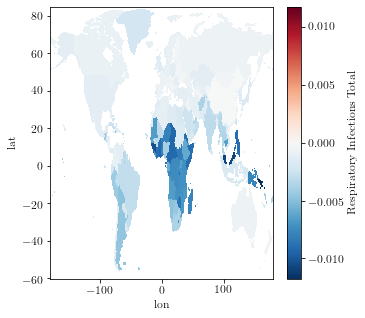

In [633]:
test_lri.plot();